In [47]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import glob
import numpy as np

cudnn.benchmark = True

In [48]:
root_directory = os.path.join("data", "data_m")

train_images_filepaths  = glob.glob(os.path.join(root_directory, "train", "*", "*"))
val_images_filepaths    = glob.glob(os.path.join(root_directory, "val", "*", "*"))
test_images_filepaths   = glob.glob(os.path.join(root_directory, "test", "*", "*"))
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

383 109 58


In [49]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = int(np.ceil(len(images_filepaths) / cols))
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color, size=20)
        ax.ravel()[i].set_axis_off()
    for i in range(rows * cols - len(images_filepaths)):
        ax.ravel()[(-1*(rows * cols - len(images_filepaths) - i))].set_axis_off()
    plt.tight_layout()
    plt.show()

In [50]:
display_image_grid(random.sample(test_images_filepaths,10))

In [51]:
class ConvRetDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "retina":
            label = 1
        else:
            label = 0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [52]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = ConvRetDataset(images_filepaths=train_images_filepaths, transform=train_transform)

val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = ConvRetDataset(images_filepaths=val_images_filepaths, transform=val_transform)

In [53]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

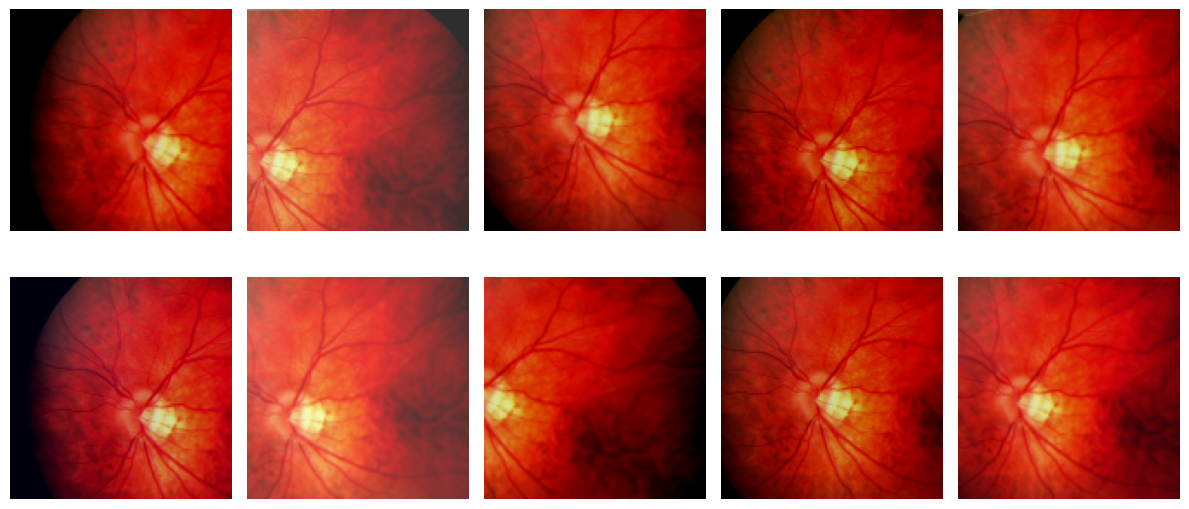

In [54]:
random.seed(42)
visualize_augmentations(train_dataset)

In [55]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [56]:
params = {
    "model": "densenet121",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 4,
    "num_workers": 0,
    "epochs": 10,
}

In [57]:
model = getattr(models, params["model"])(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier  = nn.Sequential(nn.Linear(num_ftrs, 500),nn.Linear(500,  2))
model = model.to(params["device"])
criterion = nn.CrossEntropyLoss().to(params["device"])
optimizer = torch.optim.SGD(model.parameters(), lr=params["lr"], momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [58]:
train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [59]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(images)
        loss = criterion(output, target)
        accuracy = torch.mean(target.eq(torch.argmax(output, dim=1)).to(torch.float)).item()
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [60]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images)
            loss = criterion(output, target)
            accuracy = torch.mean(target.eq(torch.argmax(output, dim=1)).to(torch.float)).item()

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [61]:
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

Epoch: 1. Train.      Loss: 0.602 | Accuracy: 0.665: 100%|██████████| 96/96 [01:58<00:00,  1.23s/it]
Epoch: 1. Validation. Loss: 0.654 | Accuracy: 0.679: 100%|██████████| 28/28 [00:24<00:00,  1.13it/s]
Epoch: 2. Train.      Loss: 0.537 | Accuracy: 0.788: 100%|██████████| 96/96 [02:45<00:00,  1.72s/it]
Epoch: 2. Validation. Loss: 0.593 | Accuracy: 0.705: 100%|██████████| 28/28 [00:32<00:00,  1.16s/it]
Epoch: 3. Train.      Loss: 0.556 | Accuracy: 0.746: 100%|██████████| 96/96 [02:20<00:00,  1.46s/it]
Epoch: 3. Validation. Loss: 0.633 | Accuracy: 0.661: 100%|██████████| 28/28 [00:26<00:00,  1.07it/s]
Epoch: 4. Train.      Loss: 0.484 | Accuracy: 0.758: 100%|██████████| 96/96 [01:54<00:00,  1.19s/it]
Epoch: 4. Validation. Loss: 0.559 | Accuracy: 0.732: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
Epoch: 5. Train.      Loss: 0.502 | Accuracy: 0.755: 100%|██████████| 96/96 [02:00<00:00,  1.25s/it]
Epoch: 5. Validation. Loss: 0.434 | Accuracy: 0.777: 100%|██████████| 28/28 [00:29<00:00,  

In [79]:
test_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
test_dataset = ConvRetDataset(images_filepaths=test_images_filepaths, transform=test_transform)
test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(images)
        loss = criterion(output, target)
        accuracy = torch.mean(target.eq(torch.argmax(output, dim=1)).to(torch.float)).item()
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [85]:
model = model.eval()
predicted_labels = []
metric_monitor = MetricMonitor()
stream = tqdm(test_loader)
with torch.no_grad():
    for i, (images, target) in  enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(images)
        predictions = torch.argmax(output, dim=1)
        predicted_labels += ["retina" if is_cat else "control" for is_cat in predictions]
        accuracy = torch.mean(target.eq(torch.argmax(output, dim=1)).to(torch.float)).item()
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        stream.set_description(
            "Test.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

Test.      Loss: 0.214 | Accuracy: 0.817: 100%|██████████| 15/15 [00:31<00:00,  2.07s/it]


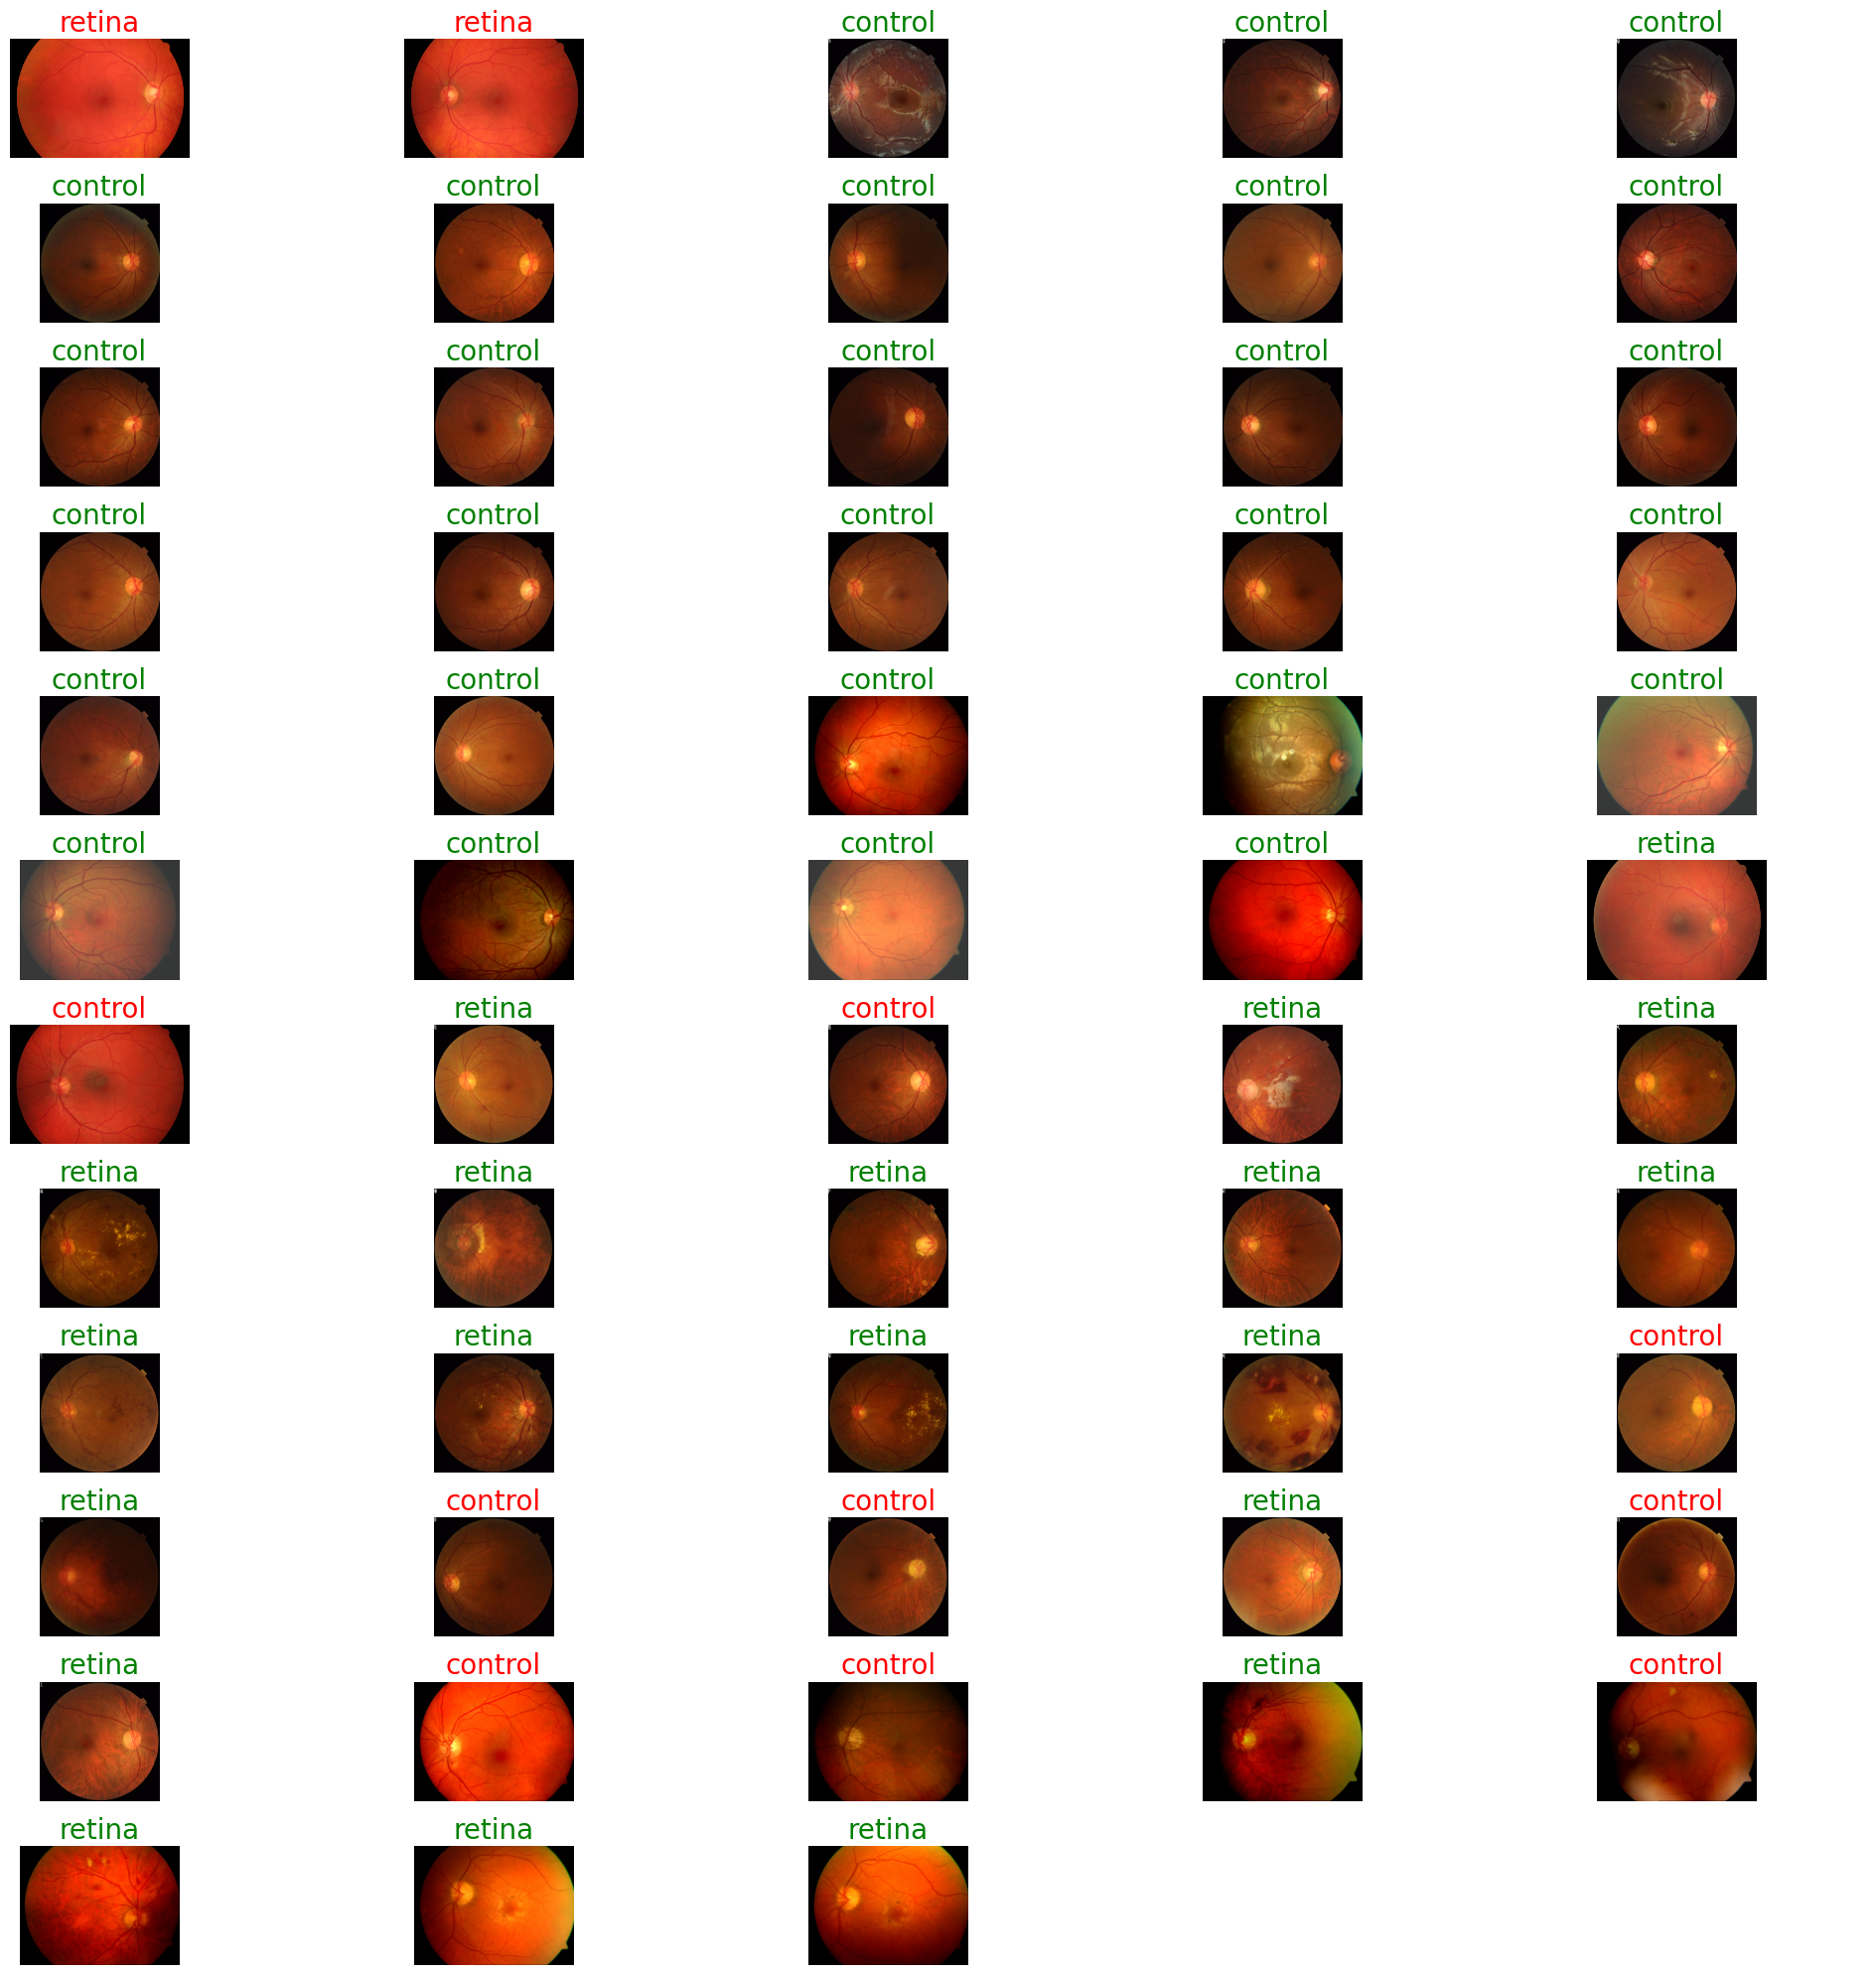

In [74]:
display_image_grid(test_images_filepaths, predicted_labels)